In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import surprise
import multiprocessing

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

from surprise import accuracy, Dataset, KNNBasic, Reader, KNNWithZScore, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import SVD



from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Leggo i dati 
df = pd.read_json(r"renttherunway_final_data.json.gz", lines=True)

# Visualizzo le prime 5 righe
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


# PROGETTO BASE

# 1 - Analisi esplorativa

In [31]:
# Informazioni dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB
None


In [32]:
df.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


<AxesSubplot:>

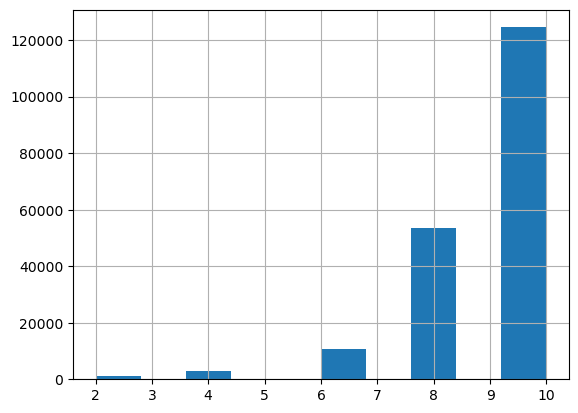

In [33]:
# Istogramma dei rating
df['rating'].hist()

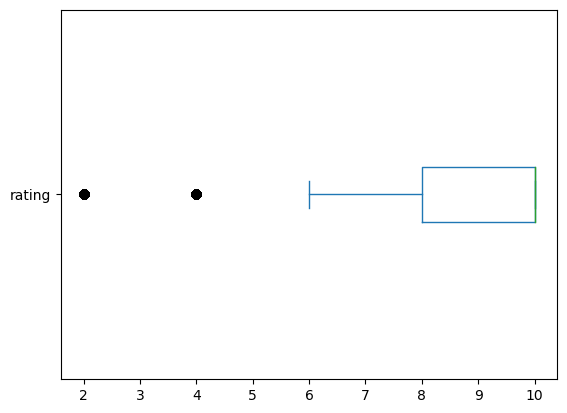

In [34]:
# Box-plot
p = df.rating.plot.box(vert = False, sym = 'k')

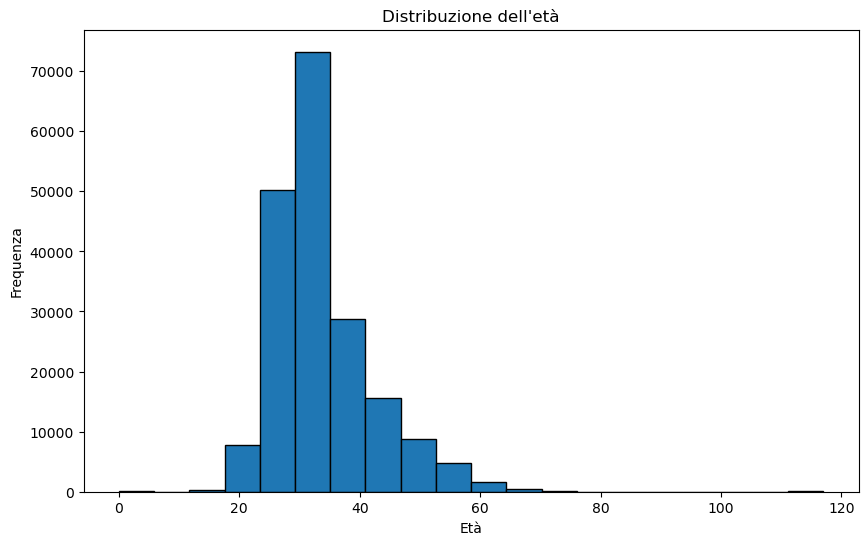

In [35]:
age_data = df['age'].dropna()
plt.figure(figsize=(10, 6))
plt.hist(age_data, bins=20, edgecolor='k')
plt.xlabel('Età')
plt.ylabel('Frequenza')
plt.title('Distribuzione dell\'età')
plt.show()


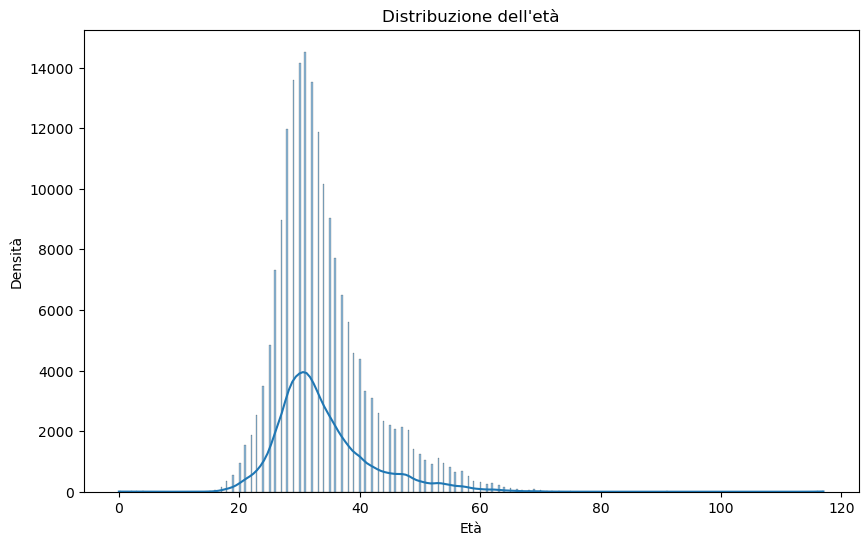

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(age_data, kde=True)
plt.xlabel('Età')
plt.ylabel('Densità')
plt.title('Distribuzione dell\'età')
plt.show()

C:\Users\loren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


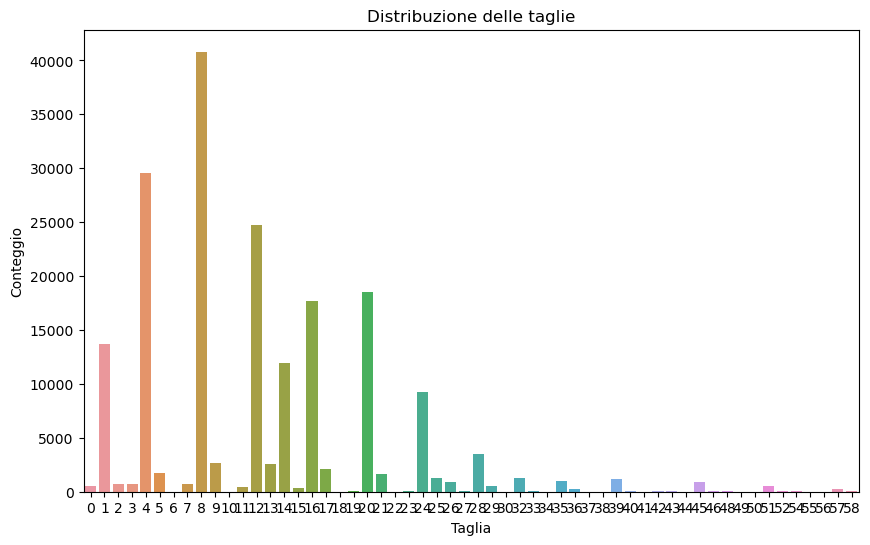

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(df['size'])
plt.xlabel('Taglia')
plt.ylabel('Conteggio')
plt.title('Distribuzione delle taglie')
plt.show()


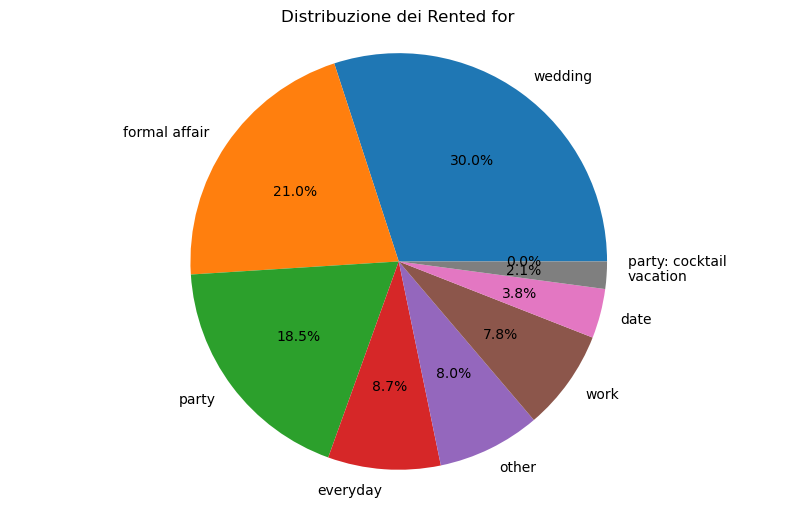

In [38]:
rented_for_data = df['rented for'].dropna()
rented_for_counts = rented_for_data.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(rented_for_counts.values, labels=rented_for_counts.index, autopct='%1.1f%%')
plt.title('Distribuzione dei Rented for')
plt.axis('equal')
plt.show()


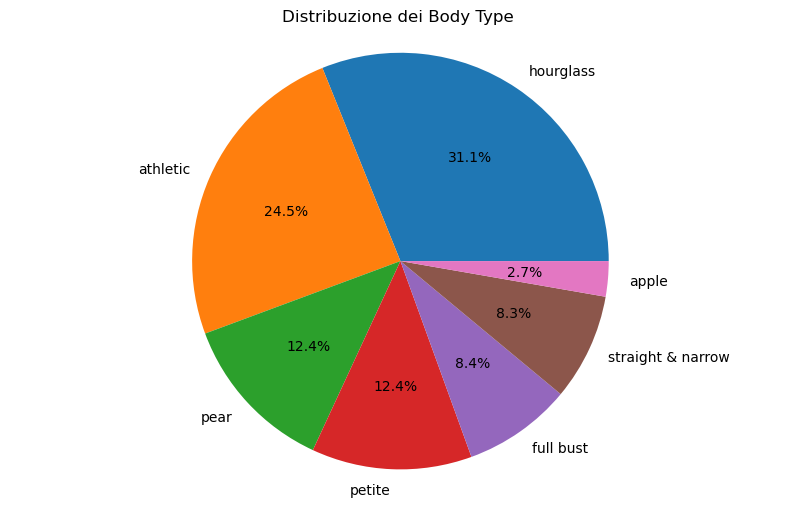

In [39]:
body_type_data = df['body type'].dropna()
body_type_counts = body_type_data.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(body_type_counts.values, labels=body_type_counts.index, autopct='%1.1f%%')
plt.title('Distribuzione dei Body Type')
plt.axis('equal')
plt.show()

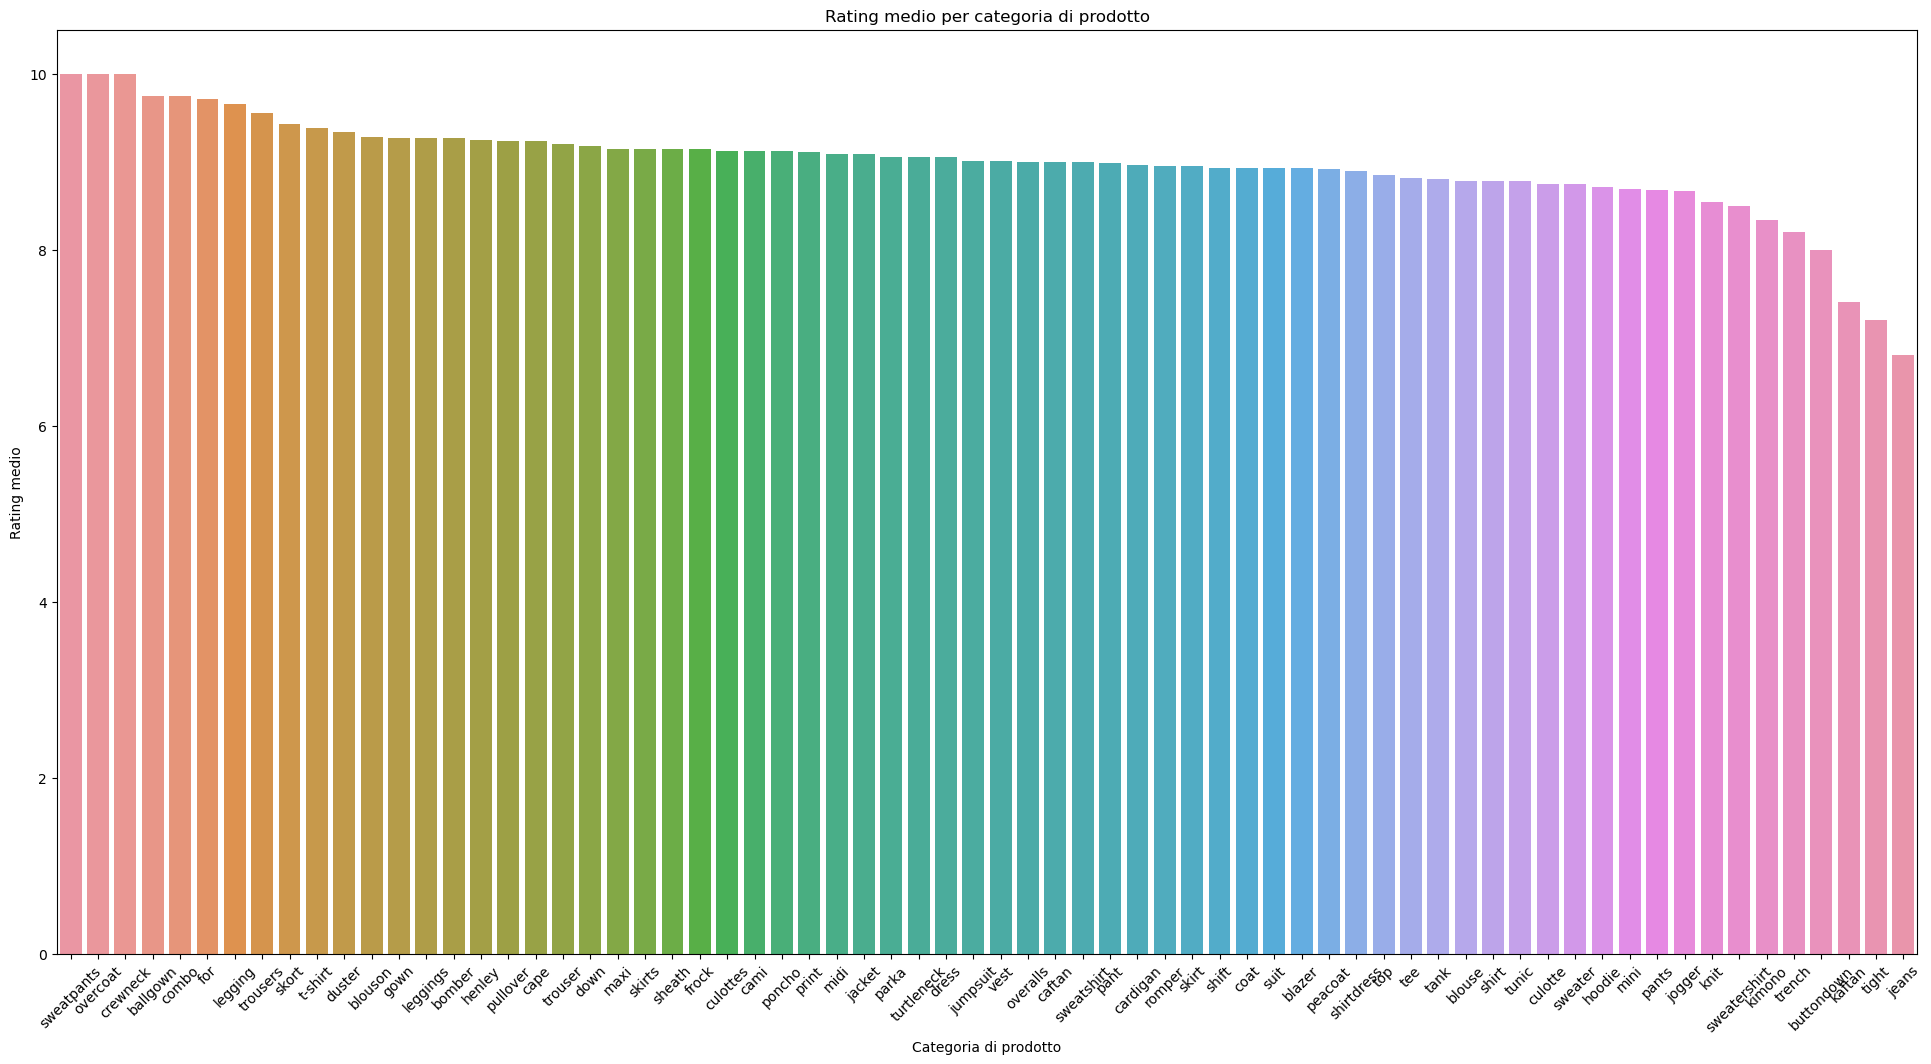

In [40]:
average_rating_by_category = df.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(24, 12))
sns.barplot(x=average_rating_by_category.index, y=average_rating_by_category.values)
plt.xlabel('Categoria di prodotto')
plt.ylabel('Rating medio')
plt.title('Rating medio per categoria di prodotto')
plt.xticks(rotation=45)
plt.show()


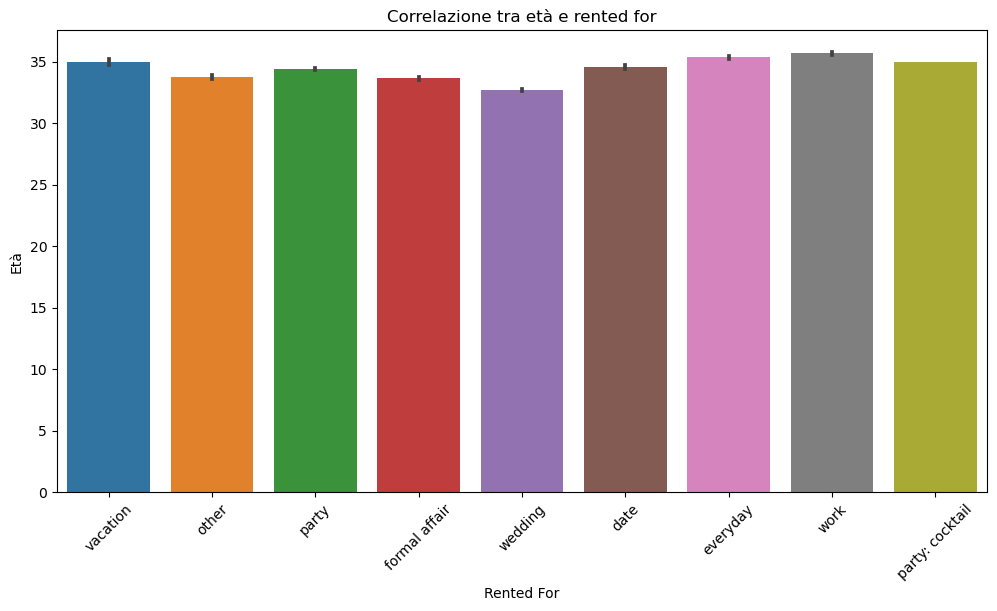

In [41]:
subset = df[['age', 'rented for']].dropna()

plt.figure(figsize=(12, 6))
sns.barplot(x='rented for', y='age', data=subset)
plt.xlabel('Rented For')
plt.ylabel('Età')
plt.title('Correlazione tra età e rented for')
plt.xticks(rotation=45)
plt.show()

# 2 - K-NN

Prima delle operazioni per ridurre il dataset mantenendo i dati più significativi

In [4]:
# Seleziono gli utenti più attivi
user_interaction_counts = df['user_id'].value_counts()
a = 20  # Soglia minima di interazioni
active_users = user_interaction_counts[user_interaction_counts >= a].index
filtered_dataframe = df[df['user_id'].isin(active_users)]

In [5]:
# Seleziono gli item più recensiti
user_interaction_counts = df['item_id'].value_counts()
b = 20  # Soglia minima di interazioni
active_users = user_interaction_counts[user_interaction_counts >= b].index
filtered_dataframe = filtered_dataframe[filtered_dataframe['item_id'].isin(active_users)]

In [6]:
filtered_dataframe

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
55,fit,112436,32b,298830,115lbs,10.0,work,I liked this one more than I thought I would! ...,straight & narrow,Love this!,shift,"5' 7""",4,30.0,"September 8, 2016"
59,fit,234006,34c,206536,135lbs,10.0,wedding,This dress is absolutely gorgeous and has an e...,hourglass,Beautiful dress for a wedding or gala event,dress,"5' 8""",12,34.0,"June 1, 2017"
66,fit,269712,34d,259136,125lbs,8.0,work,I was wavering between true to size and large....,full bust,Great work dress,sheath,"5' 2""",8,32.0,"March 1, 2016"
78,fit,434928,32b,2429745,125lbs,10.0,vacation,Incredibly comfortable and really flattering. ...,straight & narrow,Love this Romper!,romper,"5' 9""",8,36.0,"March 24, 2017"
159,fit,32925,34b,985087,122lbs,10.0,other,This is one of my favorite gowns on the site. ...,straight & narrow,Stylist Review!,gown,"5' 7""",4,26.0,"April 21, 2015"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192459,fit,252311,32c,451969,105lbs,10.0,other,This dress was amazing! I was always a little ...,petite,Stylist Review,sheath,"5' 2""",4,25.0,"January 25, 2016"
192477,fit,616450,34b,1906757,NaN,10.0,date,LOVE this dress! The color is perfect and I li...,hourglass,Stylist Review,dress,"5' 4""",1,26.0,"December 16, 2017"
192521,small,691468,34c,1000739,125lbs,10.0,party,"like most E&J dresses, this runs a bit small. ...",full bust,awesome staple in any wardrobe,dress,"5' 3""",12,31.0,"November 9, 2015"
192530,fit,404345,32c,1539576,135lbs,10.0,work,"Great dress to wear to work, or would be perfe...",pear,Perfect Work or Holiday Dress,dress,"5' 8""",8,32.0,"September 13, 2017"


In [7]:
# Conto gli elementi NaN in rating
nan_count = filtered_dataframe['rating'].isna().sum()
print("Il numero di elementi NaN nella colonna 'rating' è:", nan_count)

# Elimina le righe contenenti elementi NaN
filtered_dataframe.dropna(subset=['rating'], inplace=True)

Il numero di elementi NaN nella colonna 'rating' è: 0


In [8]:
# Creazione della matrice di rating
rating_matrix = filtered_dataframe.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean')
rating_matrix = pd.DataFrame(rating_matrix)

# Visualizzazione della matrice di rating
rating_matrix

item_id,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,...,2935830,2936514,2936752,2937389,2940176,2948324,2954118,2955585,2955734,2958376
user_id,,,,,,,,,,,,,,,,,,,,,
2042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
984633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN
994398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN


In [9]:
# Converto il DataFrame nel formato di surprise
reader = Reader(rating_scale=(0, 10)) #rating minimo 0, massimo 10
dataset_surprise = Dataset.load_from_df(filtered_dataframe[['user_id', 'item_id', 'rating']], reader)

algo = KNNBasic()

# Divido il dataset in train e test set
trainset, testset = train_test_split(dataset_surprise, test_size=0.2)

# Alleno e testo l'algoritmo
algo.fit(trainset)
predictions = algo.test(testset)

# Compute metrics
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 2.4882
RMSE: 1.5774


In [10]:
# Cross validation
kfold_result = cross_validate(algo, dataset_surprise, cv=5, measures=['mse', 'rmse'], verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MSE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     2.6362  2.7422  2.5944  2.5844  2.6788  2.6472  0.0581  
RMSE (testset)    1.6236  1.6560  1.6107  1.6076  1.6367  1.6269  0.0178  
Fit time          0.02    0.00    0.00    0.00    0.00    0.00    0.01    
Test time         0.02    0.01    0.01    0.00    0.02    0.01    0.01    


In [11]:
# Definisco la griglia di parametri
param_grid = {
    'k': np.arange(2, 41, 2),
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False],
    },
}

# Inizializzo e alleno la Grid Search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mse"], cv=5, n_jobs=-1)
gs.fit(dataset_surprise)

In [12]:
# Miglior RMSE
print(f'Best RMSE = {gs.best_score["rmse"]:.4f}')

# Combinazioni dei parametri che danno il miglior RMSE
print(f'Best configuration = {gs.best_params["rmse"]}')

Best RMSE = 1.3787
Best configuration = {'k': 2, 'sim_options': {'name': 'pearson', 'user_based': True}}


In [13]:
# Salvo la configurazione ottimale
best_config = gs.best_params['rmse']
algo = KNNBasic(k=best_config['k'], sim_options=best_config['sim_options'], verbose=True)

In [14]:
# Ricalcolo MSE e RMSE con la configurazione ottimale
algo.fit(trainset)
predictions = algo.test(testset)

mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
MSE: 1.8070
RMSE: 1.3442


# 3 - Filling della matrice

In [53]:
# Previsione dei valori per il testset utilizzando l'algoritmo ottimale
predictions_optimal = algo.test(testset)

# Creo una matrice vuota con le stesse dimensioni di rating_matrix
filled_rating_matrix_knn = rating_matrix.copy()

# Riempio la matrice con le previsioni dell'algoritmo ottimale
for user_id in filled_rating_matrix_knn.index:
    for item_id in filled_rating_matrix_knn.columns:
        pred_rating = algo.predict(user_id, item_id).est
        filled_rating_matrix_knn.loc[user_id, item_id] = pred_rating

# Visualizzare la matrice di rating riempita con la configurazione ottimale
print("Matrice di rating riempita con la configurazione ottimale:")
filled_rating_matrix_knn

Matrice di rating riempita con la configurazione ottimale:


item_id,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,...,2935830,2936514,2936752,2937389,2940176,2948324,2954118,2955585,2955734,2958376
user_id,,,,,,,,,,,,,,,,,,,,,
2042,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
5353,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
20659,9.111514,9.111514,9.111514,10.000000,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
21281,9.111514,9.111514,9.111514,10.000000,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
24189,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984042,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514
984633,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,10.000000,9.111514,10.000000,9.111514,9.111514,9.111514,9.111514,9.111514
994398,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,...,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,9.111514,10.000000,9.111514,9.111514


# 4 - Clustering K-means con cosine similarity

In [54]:
# Calcolo la cosine similarity tra gli utenti
user_similarity = cosine_similarity(filled_rating_matrix_knn)

# Creo un oggetto KMeans per eseguire il clustering
kmeans = KMeans(n_clusters=6)

# Eseguo il clustering
clusters = kmeans.fit_predict(user_similarity)

# Creo un dataframe con gli utenti e le relative etichette di cluster
segmented_users_df = pd.DataFrame({'user_id': filled_rating_matrix_knn.index, 'cluster_label': clusters})

# Visualizzo i risultati della segmentazione
print("Segmentazione degli utenti:")
segmented_users_df

Segmentazione degli utenti:


,user_id,cluster_label
0,2042,0
1,5353,0
2,20659,1
3,21281,1
4,24189,0
...,...,...
285,984042,0
286,984633,0
287,994398,0
288,995412,2


In [55]:
# Calcolo il coefficiente di Silhouette
silhouette_coefficient = silhouette_score(user_similarity, clusters)

# Stampo il coefficiente di Silhouette
print("Silhouette Score:", silhouette_coefficient.round(2))

Silhouette Score: 0.64


# 5 - Lista di Item da consigliare

In [56]:
# Lista degli utenti presenti nel dataset
users_list = filtered_dataframe['user_id'].unique()

# items_to_recommend serve per memorizzare le liste di items consigliati per ogni utente
items_to_recommend = {}

# Iterare su ogni utente
for user in users_list:
    # Prendo l'ID degli items già interagiti dall'utente
    interacted_items = filtered_dataframe[filtered_dataframe['user_id'] == user]['item_id'].unique()
    
    # Prendo i rating predetti per gli items non interagiti dall'utente
    unrated_items = filtered_dataframe[~filtered_dataframe['item_id'].isin(interacted_items)]['item_id'].unique()
    predicted_ratings = [algo.predict(user, item).est for item in unrated_items]
    
    # Creo la lista degli n items da consigliare per l'utente
    n = 5  # Numero di items da consigliare
    recommended_items = [item for _, item in sorted(zip(predicted_ratings, unrated_items), reverse=True)][:n]
    
    items_to_recommend[user] = recommended_items

# Visualizzo le liste degli items consigliati per ogni utente
for user, recommended_items in items_to_recommend.items():
    print(f"Utente: {user}, Items consigliati: {recommended_items}")


Utente: 112436, Items consigliati: [2958376, 2955734, 2955585, 2954118, 2948324]
Utente: 234006, Items consigliati: [2958376, 2955734, 2955585, 2954118, 2948324]
Utente: 269712, Items consigliati: [2872227, 2848341, 2845075, 2841727, 2822800]
Utente: 434928, Items consigliati: [2794512, 1750560, 1717057, 1692512, 1390540]
Utente: 32925, Items consigliati: [2958376, 2955734, 2955585, 2954118, 2948324]
Utente: 845608, Items consigliati: [2755484, 2701429, 1893305, 1821947, 1391906]
Utente: 933801, Items consigliati: [2821340, 2783742, 2660685, 2628747, 2620667]
Utente: 45337, Items consigliati: [2821340, 2783742, 2660685, 2628747, 2620667]
Utente: 918534, Items consigliati: [2758251, 2340996, 1947410, 1678888, 1598962]
Utente: 491589, Items consigliati: [2841727, 2557055, 2478494, 2286628, 2146328]
Utente: 887647, Items consigliati: [2958376, 2955734, 2955585, 2954118, 2948324]
Utente: 359031, Items consigliati: [2758251, 2653183, 2382109, 2340996, 1965742]
Utente: 262124, Items consigli

# 6 - Matrix Factorization

In [57]:
# Inizializzo l'algoritmo SVD
svd = SVD()  

# Addestro l'algoritmo
svd.fit(trainset)

# Genero le previsioni
predictions_svd = svd.test(testset)

print("Matrix Factorization (SVD):")
mse_svd = accuracy.mse(predictions_svd)
rmse_svd = accuracy.rmse(predictions_svd)

Matrix Factorization (SVD):
MSE: 1.6508
RMSE: 1.2848


In [58]:
# Creo una copia di rating_matrix
filled_rating_matrix_svd = rating_matrix.copy()

# Prendo gli indici dei rating mancanti
missing_indices = filled_rating_matrix_svd.isna()

for i, j in zip(*missing_indices.values.nonzero()):
    # Esegui la previsione del il rating mancante
    user_id = filled_rating_matrix_svd.index[i]
    item_id = filled_rating_matrix_svd.columns[j]
    predicted_rating = svd.predict(user_id, item_id).est
    
    # Assegno il valore predetto al rating mancante nella matrice di rating
    filled_rating_matrix_svd.iloc[i, j] = predicted_rating

filled_rating_matrix_svd

item_id,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,...,2935830,2936514,2936752,2937389,2940176,2948324,2954118,2955585,2955734,2958376
user_id,,,,,,,,,,,,,,,,,,,,,
2042,8.970053,9.200119,9.181075,9.214998,9.188870,9.047545,9.300684,9.333213,8.447873,9.459619,...,9.250737,8.638262,9.519301,8.874313,8.875588,9.068719,8.881213,9.203919,9.237758,9.306648
5353,9.464195,9.681872,9.490080,9.672205,9.494298,9.537927,9.539312,9.789285,8.802367,9.772065,...,9.866006,8.887065,9.750175,9.493305,9.478834,9.341870,9.212677,9.577841,9.645531,9.528457
20659,8.440880,8.822835,8.432660,8.756958,8.704647,8.672252,8.791442,8.824817,7.903693,9.008482,...,8.777271,7.918161,8.675228,8.402000,8.659399,8.426255,8.312727,8.657380,8.800400,8.645327
21281,8.913007,9.783452,9.298825,9.347190,9.422955,9.320322,9.544139,9.526309,8.533853,9.563293,...,9.468699,9.143836,9.334108,9.254596,9.453655,9.188172,9.211957,9.462224,9.258509,9.435754
24189,8.672584,8.971877,8.978311,8.987542,9.014593,8.966021,9.207900,9.183178,8.308007,9.289629,...,9.179279,8.415964,9.245848,8.811697,9.059841,8.990485,8.610615,8.958730,9.078727,8.851532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984042,9.196597,9.627500,9.236255,9.559022,9.300794,9.318505,9.474747,9.761755,8.636354,9.414885,...,9.328426,9.233280,9.338651,9.261412,9.492213,8.908035,9.062060,9.390231,9.142484,9.437342
984633,8.408927,8.954478,8.784125,8.904414,8.816393,8.852648,8.935719,8.965233,8.235535,8.902453,...,8.924724,8.412599,10.000000,8.661338,8.916858,8.734442,8.684307,9.003484,10.000000,8.827388
994398,9.053612,9.464839,9.047276,9.576492,9.193778,9.095788,9.349421,9.526221,8.680250,9.530186,...,9.376979,9.049097,9.542610,9.299291,9.638046,8.974584,9.027469,10.000000,9.247106,9.410783


# Progetto intermedio

# 1 - Problema multi-obiettivo

In [59]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import math
# Algorithms
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA

# Core classes
from pymoo.core.callback import Callback
from pymoo.core.crossover import Crossover
from pymoo.core.evaluator import Evaluator
from pymoo.core.individual import Individual
from pymoo.core.mutation import Mutation
from pymoo.core.population import Population
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.core.repair import Repair
from pymoo.core.sampling import Sampling
from pymoo.core.termination import NoTermination

# Performance metrics
from pymoo.indicators.hv import HV

# Genetic operator
from pymoo.operators.crossover.expx import ExponentialCrossover
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.pntx import  PointCrossover, SinglePointCrossover, TwoPointCrossover
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.sampling.rnd import BinaryRandomSampling, FloatRandomSampling
from pymoo.operators.selection.rnd import RandomSelection
from pymoo.operators.selection.tournament import TournamentSelection

# Optimization interface
from pymoo.optimize import minimize

# Problem utilities
from pymoo.problems import get_problem
from pymoo.problems.many.dtlz import DTLZ1
from pymoo.problems.functional import FunctionalProblem
from pymoo.problems.static import StaticProblem

# Operator utilities
from pymoo.operators.repair.rounding import RoundingRepair

# Termination criterion
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination, DefaultSingleObjectiveTermination
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.xtol import DesignSpaceTermination

# General utilities
from pymoo.util import plotting
from pymoo.util.plotting import plot
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

# Plotting utilities
from pymoo.visualization.fitness_landscape import FitnessLandscape
from pymoo.visualization.heatmap import Heatmap
from pymoo.visualization.scatter import Scatter
from pymoo.visualization.petal import Petal
from pymoo.visualization.pcp import PCP
from pymoo.visualization.radar import Radar
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover

In [60]:
# Creo una copia di rating_matrix
rm = rating_matrix.copy()

# Converto tutti i NaN in -1 e cambio il tipo di dati in int
rm = rm.fillna(-1)
rm = rm.astype(int)

# Campiono il 5% dei dati
rm = rm.sample(frac=0.05, replace=True, random_state=1).sort_index(0)

# Assegno ad M il valore delle righe e a N il valore delle colonne
M = rm.shape[0]
N = rm.shape[1]
rm

C:\Users\loren\AppData\Local\Temp\ipykernel_19504\2926720130.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  rm = rm.sample(frac=0.05, replace=True, random_state=1).sort_index(0)


item_id,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,...,2935830,2936514,2936752,2937389,2940176,2948324,2954118,2955585,2955734,2958376
user_id,,,,,,,,,,,,,,,,,,,,,
116211,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
234255,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
235111,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
404424,-1,-1,8,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
422015,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
461191,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
577688,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
675604,-1,-1,-1,-1,-1,-1,-1,-1,-1,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
776484,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [61]:
# Converto tutti i NaN in -1 e cambio il tipo di dati in int
rating_matrix = rating_matrix.fillna(-1)
rating_matrix = rating_matrix.astype(int)

# Resetto l'indice
rating_matrix.reset_index(inplace=True)
rating_matrix

item_id,user_id,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2935830,2936514,2936752,2937389,2940176,2948324,2954118,2955585,2955734,2958376
0,2042,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,5353,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,20659,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,21281,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,24189,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,984042,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
286,984633,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,10,-1,-1,-1,-1,-1,10,-1
287,994398,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,10,-1,-1
288,995412,-1,-1,8,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [62]:
# Creo una copia di filtered_dataframe, raggruppo e conto 'item_id',
# elimino le colonne che non mi servono e creo la colonna 'N_j'
tmp = filtered_dataframe.copy()
tmp = filtered_dataframe.groupby(['item_id']).count()
tmp.drop(['fit', 'bust size', 'weight', 'rating', 'rented for', 'review_text', 'body type', 'review_summary', 'category', 'height', 'size', 'age', 'review_date'], axis=1, inplace=True)
tmp.rename(columns={'user_id': 'cont'}, inplace=True)
tmp['N_j'] = 0.0

L = 10

for x in tmp.index:
  tmp.N_j[x] = math.log(M/tmp.cont[x], 2)
colonne = rm.columns
tmp


C:\Users\loren\AppData\Local\Temp\ipykernel_19504\2161507226.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.N_j[x] = math.log(M/tmp.cont[x], 2)


,cont,N_j
item_id,,
123793,5,1.485427
124204,3,2.222392
124553,5,1.485427
125424,4,1.807355
125465,2,2.807355
...,...,...
2948324,6,1.222392
2954118,3,2.222392
2955585,1,3.807355


In [63]:
# Definisco il problema
class OptimizationProblem(ElementwiseProblem):
  def __init__(self):
    super().__init__(n_var=M*N, #matrice fillata
    n_obj=3, # numero funz. obiettivo
    n_constr=0, # numero vincoli
    xl= np.zeros(M*N), # lower bound
    xu= np.ones(M*N) # upper bound
    )

  def _evaluate(self, x, out, *args, **kwargs):
    out['F'] = np.array([accuracy(x), coverage(x), novelty(x)])
    

n_item = list(rating_matrix.columns)

# accuracy(x) calcola l'accuratezza del modello di raccomandazione x
def accuracy(x): 
  v=np.matrix(x.reshape((M, N)))
  sum=0
  for i in range(M):
    for j in range(N):
      if v[i, j] == 1:
        item=n_item[j+1]
        sum=sum + rating_matrix[item][i]
  sum=sum/(M*L)
  return -sum

# coverage(x) calcola la copertura del modello di raccomandazione 
def coverage(x): 
  v=np.matrix(x.reshape((M, N)))
  cont=0
  indice=0
  app=np.zeros(N)
  for i in range(M):
    for j in range(N):
      if v[i, j] == 1:
        item=int(n_item [j+1])
        if item not in app:
          app[indice]=item
          indice=indice+1
  return -(indice/N)

# novelty(x) calcola la novità del modello di raccomandazione
def novelty(x): 
  v=np.matrix(x.reshape((M, N)))
  sum=0
  for i in range(M):
    for j in range(N):
      if v[i, j] == 1:
        item=int(n_item [j+1])
        b=float(tmp[tmp.index == item]['N_j'])
        c=b/(L-1)
        sum=sum+c
  return -(sum/M)

In [64]:
# MySampling implementa la strategia di campionamento per il problema
# per ogni utente vengono selezionati 10 item non ancora valutati e viene generata una soluzione
class MySampling (Sampling) :
  def _do (self, problem:OptimizationProblem, n_samples: int, **kwargs) :
    X = np.full( (n_samples, M*N), False, dtype=bool)
    for k in range (n_samples):
      for i in range (M):
        I=np.random.permutation(N)
        I=I[rm.iloc[i, I]==-1]
        I = I[:10]
        X[k, i * N + I] = True
    return X

In [65]:
# MyCrossover implementa un operatore di crossover personalizzato per il problema

class MyCrossover (Crossover):
    def __init__(self):
      super().__init__(2, 1)
    def _do (self, problem:OptimizationProblem, X, **kwargs) :
      n_parents, n_matings, n_var =X.shape
      _X = np.full((self.n_offsprings, n_matings, problem.n_var), False)
      for k in range (n_matings) :
        p1, p2 = X[0, k], X[1, k]
        both_are_true = np.logical_and(p1, p2)
        are_different = np.logical_xor(p1, p2)
        _X[0, k, both_are_true] = True
        for i in range (M):
          n_remaining = 10 - np.sum(both_are_true[i * N : (i + 1) * N])
          S = np.random.permutation (np.where (are_different [i * N : (i + 1) * N]) [0]) [:n_remaining]
          S += i * N
          _X[0, k, S] = True
      return _X

In [66]:
# MyMutation implementa un operatore di mutazione personalizzato per il problema 
class MyMutation (Mutation) :
  def _do(self, problem:OptimizationProblem, X, **kwargs) :
    for i in range (X.shape[0]):
      X[i, :]=X[i, :]
      oldX=X[i, :].copy()
      n_users_to_mutate = np.random.randint (max(1, M * 0.20))
      for _ in range (n_users_to_mutate):
        user=np.random.randint(M)
        is_true = np.where(X[i, user * N : (user + 1) * N] )[0]
        is_false = np.where(np.logical_and(
                            np.logical_not(X[i, user * N : (user + 1) * N]), 
                            rm.iloc[user, :]!=-1))[0]
        if len(is_true)!=0 and len(is_false)!=0:
          change_to_true = np.random.choice(is_false) + user * N
          change_to_false = np.random.choice(is_true) + user * N
          X[i, change_to_true] = True
          X[i, change_to_false] = False
          if np.sum(oldX) != np.sum(X[i]) :
            print (np. sum(oldX), np. sum(X[i]), change_to_true, change_to_false)
    return X

# 2 - Risoluzione del problema con NSGA2 e MOEA/D

In [67]:
# Inizializzo il problema da risolvere
problem = OptimizationProblem()
# Inizializzo l'algoritmo NSGA2
nsga2 = NSGA2(pop_size=100,
                  offspring=2,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  eliminate_duplicates=True)
# Ottimizzo il problema
res = minimize(problem,
               nsga2,
               ('n_gen', 100),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      6 |             - |             -
     2 |      200 |     12 |  0.1681052013 |         ideal
     3 |      300 |     13 |  0.1672144891 |         ideal
     4 |      400 |     16 |  0.0927835052 |         ideal
     5 |      500 |     19 |  0.1058834896 |         ideal
     6 |      600 |     19 |  0.0202020202 |         ideal
     7 |      700 |     15 |  0.1518679476 |         ideal
     8 |      800 |     18 |  0.1018518519 |         ideal
     9 |      900 |     10 |  0.1848739496 |         ideal
    10 |     1000 |     16 |  0.0556829714 |         ideal


In [68]:
# Stampo i risultato ottenuti dall'ottimizzazione con NSGA2
print("Function value: %s" % res.F[0])
print("Subset:", np.where(res.X)[0])

Function value: [ 0.76428571 -0.07368421 -3.16550479]
Subset: [ 0  0  0 ... 15 15 15]


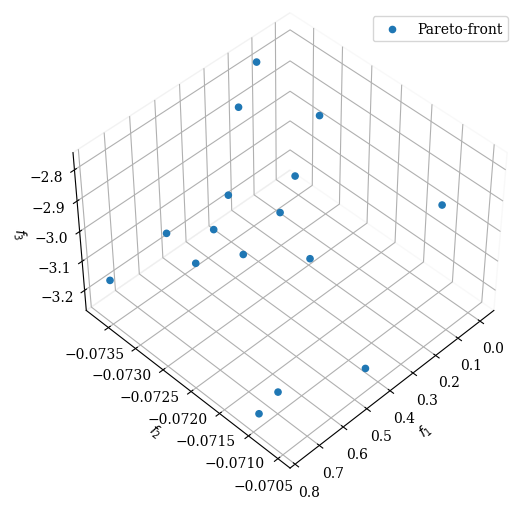

In [69]:
# Frontiera di Pareto
Scatter(legend=True).add(res.F, label="Pareto-front").show()

In [70]:
# Inizializzo il problema
problem = OptimizationProblem()

ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)

# Inizializzo l'algoritmo MOEA/D
moead = MOEAD(
    ref_dirs,
    sampling=MySampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
    n_neighbors=15,
    prob_neighbor_mating=0.7,
)

# Ottimizzo il problema
res_moead = minimize(problem,
               moead,
               ('n_gen', 100),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      5 |             - |             -
     2 |      182 |     35 |  0.5000000000 |         ideal
     3 |      273 |     20 |  1.0000000000 |         ideal
     4 |      364 |     14 |  0.0383196886 |         ideal
     5 |      455 |     52 |  1.5439593106 |         ideal
     6 |      546 |     19 |  0.0071465423 |         ideal
     7 |      637 |     73 |  2.5460351149 |         ideal
     8 |      728 |     15 |  0.0126703027 |         ideal
     9 |      819 |     20 |  1.0000000000 |         ideal
    10 |      910 |     35 |  0.0642857143 |         ideal


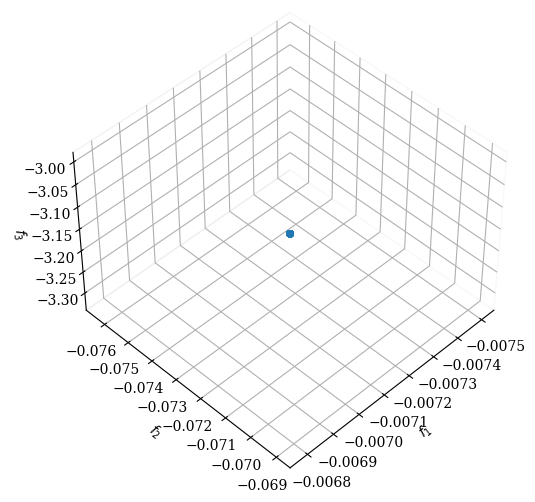

In [71]:
# Frontiera di Pareto
Scatter().add(res_moead.F).show()

In [128]:
# Stampo i risultato ottenuti dall'ottimizzazione con MOEA/D
print("Function value: %s" % res_moead.F[0])
print("Subset:", np.where(res_moead.X)[0])

Function value: [-0.52857143 -0.07263158 -3.30668963]
Subset: [ 0  0  0 ... 24 24 24]


In [129]:
# Calcolo l'indicatore di ipervolume Hypervolume per valutare
# l'approssimazione del fronte di Pareto ottenuto dagli algoritmi MOEA/D e NSGA-II 

ref_point = np.array([1.2, 1.2, 1.2])


ind = HV(ref_point=ref_point)
print("HV of approximated Pareto Front with Moea-D: ", ind(res_moead.F))
print("HV of approximated Pareto Front with Nsga-2:", ind(res.F))

HV of approximated Pareto Front with Moea-D:  9.99880967557575
HV of approximated Pareto Front with Nsga-2: 18.278766708273462


In [130]:
# Determina se una soluzione è dominata da un insieme di soluzioni 
def is_dominated(sol, res):
  for point in res:
    if all(point <= sol) and any(point < sol):
      return True
  return False

# Calcola la copertura tra due frontiere Paretiane
def coverage(pf1, pf2):
  dominated = [is_dominated(point, pf1) for point in pf2]
  return sum(dominated) / len(dominated)

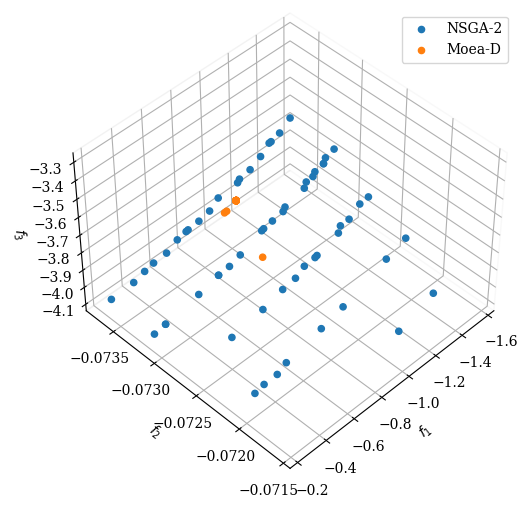

In [131]:
# Grafico delle due frontiere
Scatter(legend=True).add(res.F, label="NSGA-2").add(res_moead.F, label="Moea-D").show()

In [132]:
# Stampo i valori di coverage
print(f"C(NSGA-2, MOEA-d) = {coverage(res.F, res_moead.F)}")
print(f"C(MOEA-d, NSGA-2) = {coverage(res_moead.F, res.F)}\n")

C(NSGA-2, MOEA-d) = 1.0
C(MOEA-d, NSGA-2) = 0.0

